In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay


In [2]:
# Read the CSV files
application_df = pd.read_csv('dataset/application_record.csv')
credit_df = pd.read_csv('dataset/credit_record.csv')

# Get the unique IDs from both dataframes
application_ids = set(application_df['ID'])
credit_ids = set(credit_df['ID'])

# Find the intersection of IDs
common_ids = application_ids.intersection(credit_ids)

# Filter both dataframes to keep only the rows with common IDs
application_filtered = application_df[application_df['ID'].isin(common_ids)]
credit_filtered = credit_df[credit_df['ID'].isin(common_ids)]

# Reset the index of the filtered dataframes
application_filtered = application_filtered.reset_index(drop=True)
credit_filtered = credit_filtered.reset_index(drop=True)

# Print the number of rows in each filtered dataframe
print(f"Number of rows in filtered application dataframe: {len(application_filtered)}")
print(f"Number of rows in filtered credit dataframe: {len(credit_filtered)}")

application_filtered.to_csv('dataset/application_filtered.csv')
credit_filtered.to_csv('dataset/credit_filtered.csv')

Number of rows in filtered application dataframe: 36457
Number of rows in filtered credit dataframe: 777715


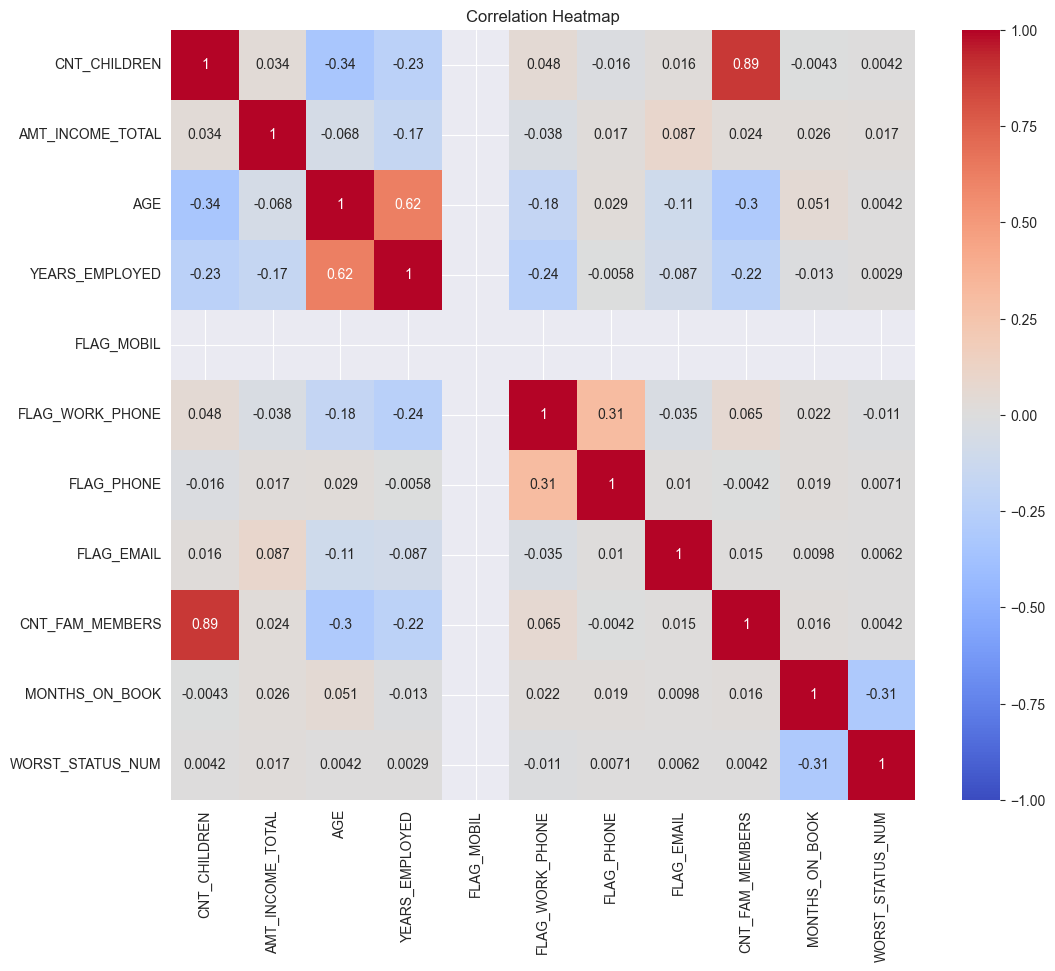

                 ID   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count  3.645700e+04  36457.000000  36457.000000     36457.000000   
mean   5.078227e+06      0.670105      0.379708         0.672189   
std    4.187524e+04      0.470181      0.485321         0.469422   
min    5.008804e+06      0.000000      0.000000         0.000000   
25%    5.042028e+06      0.000000      0.000000         0.000000   
50%    5.074614e+06      1.000000      0.000000         1.000000   
75%    5.115396e+06      1.000000      1.000000         1.000000   
max    5.150487e+06      1.000000      1.000000         1.000000   

       CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  DAYS_EMPLOYED  \
count  36457.000000      3.645700e+04  36457.000000   36457.000000   
mean       0.430315      1.866857e+05 -15975.173382   59262.935568   
std        0.742367      1.017892e+05   4200.549944  137651.334859   
min        0.000000      2.700000e+04 -25152.000000  -15713.000000   
25%        0.000000      1.215000e+05

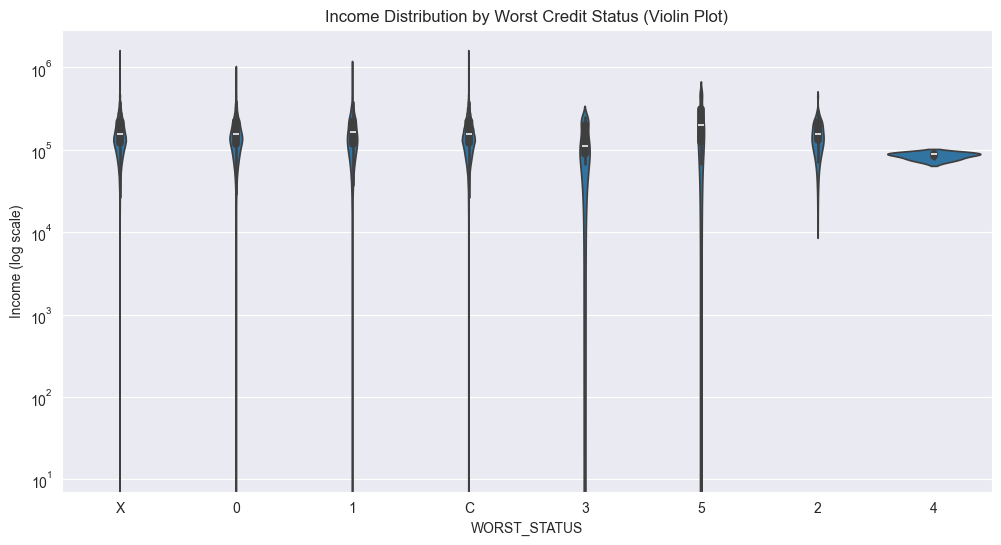

<Figure size 1200x600 with 0 Axes>

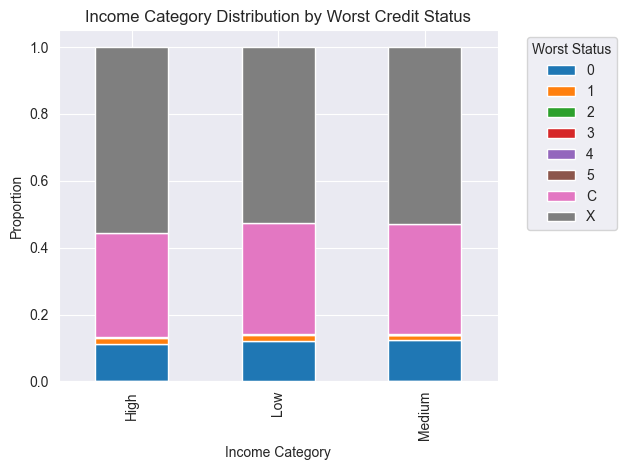

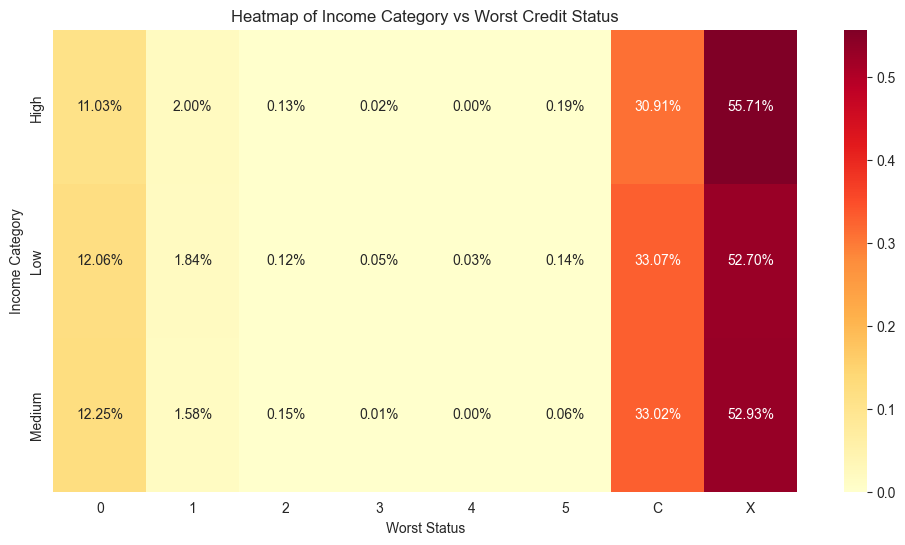

WORST_STATUS            0         1         2         3         4         5  \
INCOME_CATEGORY                                                               
High             0.110286  0.020039  0.001262  0.000223  0.000000  0.001930   
Low              0.120622  0.018398  0.001181  0.000492  0.000295  0.001377   
Medium           0.122474  0.015836  0.001482  0.000078  0.000000  0.000624   

WORST_STATUS            C         X  
INCOME_CATEGORY                      
High             0.309114  0.557147  
Low              0.330677  0.526958  
Medium           0.330213  0.529292  

Overall distribution of income categories:
INCOME_CATEGORY
High      0.369586
Medium    0.351620
Low       0.278794
Name: proportion, dtype: float64


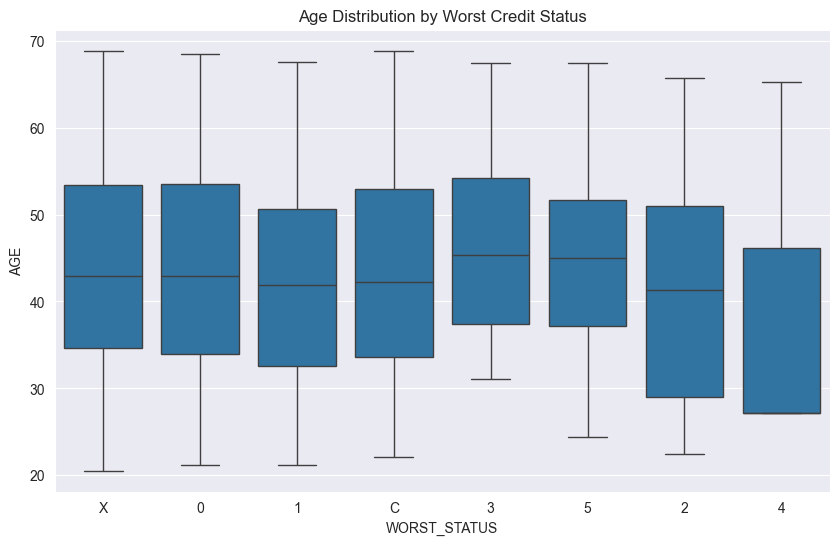

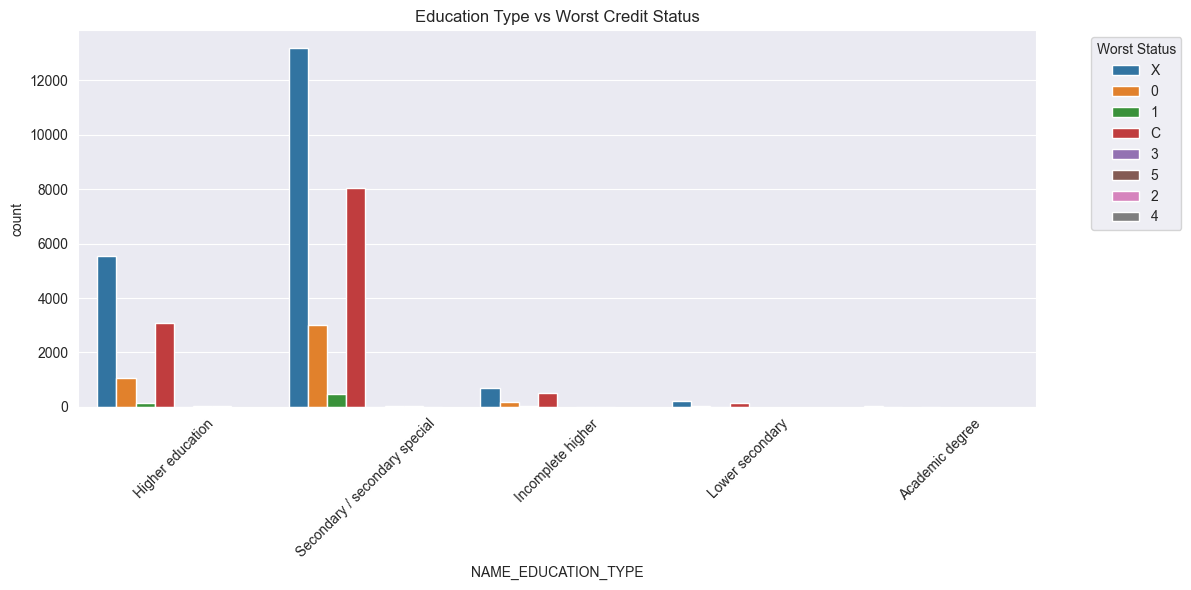

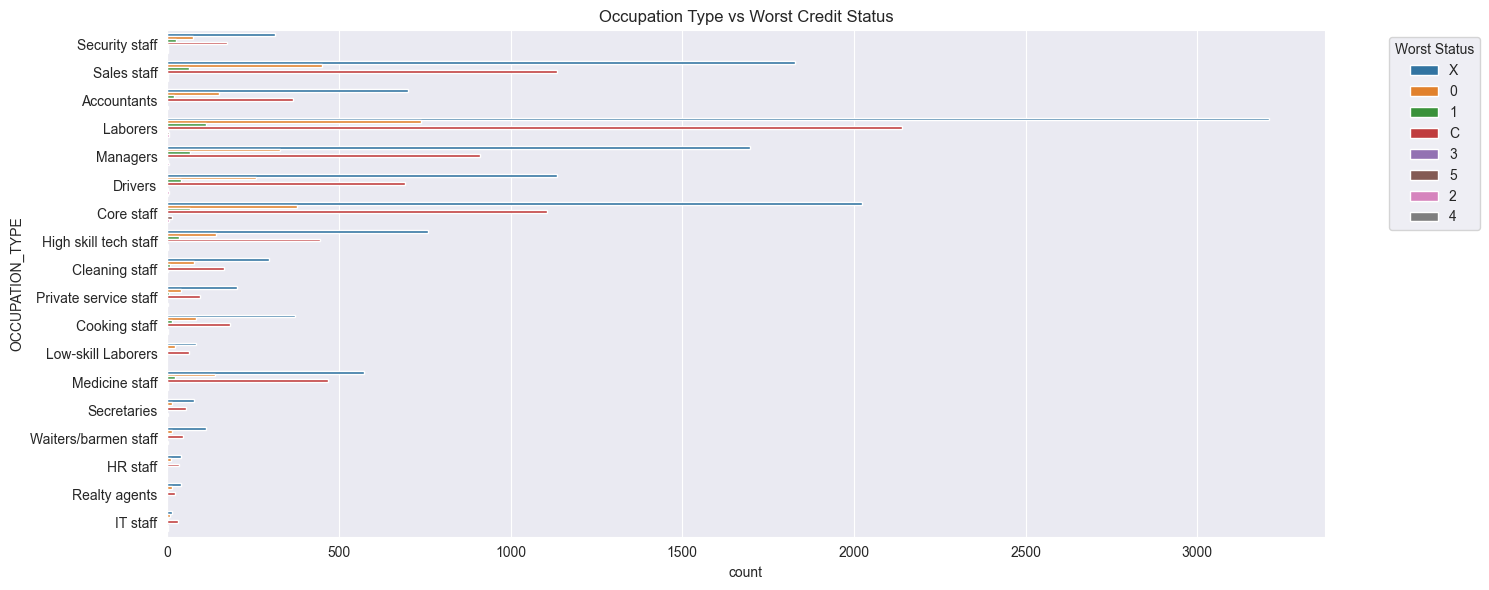


Overall default rate: 2.11%

Default rate by gender:
CODE_GENDER
0    0.02378
1    0.01973
Name: IS_DEFAULT, dtype: float64

Default rate by income type:
NAME_INCOME_TYPE
State servant           0.023451
Working                 0.022318
Commercial associate    0.019552
Pensioner               0.018205
Student                 0.000000
Name: IS_DEFAULT, dtype: float64

Default rate by age group:
AGE_GROUP
18-25    0.037940
46-55    0.023104
26-35    0.023040
65+      0.021053
36-45    0.020712
56-65    0.014725
Name: IS_DEFAULT, dtype: float64


C:\Users\eqvieira\AppData\Local\Temp\ipykernel_5648\2357287035.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = combined_df.groupby('AGE_GROUP')['IS_DEFAULT'].mean().sort_values(ascending=False)


In [3]:
# Create a summary of credit history
def get_worst_status(x):
    if 'C' in x:
        return 'C'
    else:
        return max(x) if len(x) > 0 else 'X'
    
credit_summary = credit_filtered.groupby('ID').agg({
                                                'MONTHS_BALANCE': 'count',
                                                'STATUS': lambda x: get_worst_status(x)
                                                }).reset_index()

credit_summary.columns = ['ID', 'MONTHS_ON_BOOK', 'WORST_STATUS']

# Merge application data with credit summary
combined_df = pd.merge(application_filtered, credit_summary, on='ID')

# Convert categorical variables to numeric
combined_df['CODE_GENDER'] = combined_df['CODE_GENDER'].map({'M': 0, 'F': 1})
combined_df['FLAG_OWN_CAR'] = combined_df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})
combined_df['FLAG_OWN_REALTY'] = combined_df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1})

# Convert DAYS_BIRTH and DAYS_EMPLOYED to years
combined_df['AGE'] = -combined_df['DAYS_BIRTH'] / 365
combined_df['YEARS_EMPLOYED'] = np.abs(combined_df['DAYS_EMPLOYED']) / 365

# Convert WORST_STATUS to numeric
status_order = ['C', 'X', '0', '1', '2', '3', '4', '5']
combined_df['WORST_STATUS_NUM'] = combined_df['WORST_STATUS'].apply(lambda x: status_order.index(x))

# Select numeric columns for correlation analysis
numeric_columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED',
'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
'CNT_FAM_MEMBERS', 'MONTHS_ON_BOOK', 'WORST_STATUS_NUM']

# Calculate correlation matrix
corr_matrix = combined_df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

# Print some basic statistics
print(combined_df.describe())

# Print value counts for categorical variables
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
'OCCUPATION_TYPE', 'WORST_STATUS']

for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    print(combined_df[col].value_counts(normalize=True))
    
# 1. Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='WORST_STATUS', y='AMT_INCOME_TOTAL', data=combined_df)
plt.title('Income Distribution by Worst Credit Status (Violin Plot)')
plt.yscale('log')
plt.ylabel('Income (log scale)')
plt.show()

# 2. Grouped Income Categories

# Create income categories
def categorize_income(income):
    if income < combined_df['AMT_INCOME_TOTAL'].quantile(0.33):
        return 'Low'
    elif income < combined_df['AMT_INCOME_TOTAL'].quantile(0.67):
        return 'Medium'
    else:
        return 'High'

combined_df['INCOME_CATEGORY'] = combined_df['AMT_INCOME_TOTAL'].apply(categorize_income)

# Create a contingency table
contingency_table = pd.crosstab(combined_df['INCOME_CATEGORY'], combined_df['WORST_STATUS'], normalize='index')

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.title('Income Category Distribution by Worst Credit Status')
plt.xlabel('Income Category')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Heatmap of Income Category vs Worst Status
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='.2%')
plt.title('Heatmap of Income Category vs Worst Credit Status')
plt.ylabel('Income Category')
plt.xlabel('Worst Status')
plt.show()

# Print some statistics
print(contingency_table)
print("\nOverall distribution of income categories:")
print(combined_df['INCOME_CATEGORY'].value_counts(normalize=True))

# Analyze the relationship between age and worst credit status
plt.figure(figsize=(10, 6))
sns.boxplot(x='WORST_STATUS', y='AGE', data=combined_df)
plt.title('Age Distribution by Worst Credit Status')
plt.show()

# Analyze the relationship between education and worst credit status
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_EDUCATION_TYPE', hue='WORST_STATUS', data=combined_df)
plt.title('Education Type vs Worst Credit Status')
plt.xticks(rotation=45)
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyze the relationship between occupation and worst credit status
plt.figure(figsize=(15, 6))
sns.countplot(y='OCCUPATION_TYPE', hue='WORST_STATUS', data=combined_df)
plt.title('Occupation Type vs Worst Credit Status')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate the default rate (considering status 2 or worse as default)
combined_df['IS_DEFAULT'] = combined_df['WORST_STATUS_NUM'] >= 3
default_rate = combined_df['IS_DEFAULT'].mean()
print(f"\nOverall default rate: {default_rate:.2%}")

# Analyze default rate by gender
gender_default = combined_df.groupby('CODE_GENDER')['IS_DEFAULT'].mean()
print("\nDefault rate by gender:")
print(gender_default)

# Analyze default rate by income type
income_default = combined_df.groupby('NAME_INCOME_TYPE')['IS_DEFAULT'].mean().sort_values(ascending=False)
print("\nDefault rate by income type:")
print(income_default)

# Create age groups and analyze default rate by age group
combined_df['AGE_GROUP'] = pd.cut(combined_df['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
age_default = combined_df.groupby('AGE_GROUP')['IS_DEFAULT'].mean().sort_values(ascending=False)
print("\nDefault rate by age group:")
print(age_default)

Employment Status Counts:
EMPLOYMENT_STATUS
Employed      30322
Unemployed     6135
Name: count, dtype: int64

Years Employed Statistics (for Employed individuals):
count    36457.000000
mean       174.420739
std        371.704402
min          0.046575
25%          3.202740
50%          6.898630
75%         15.558904
max       1000.665753
Name: YEARS_EMPLOYED, dtype: float64


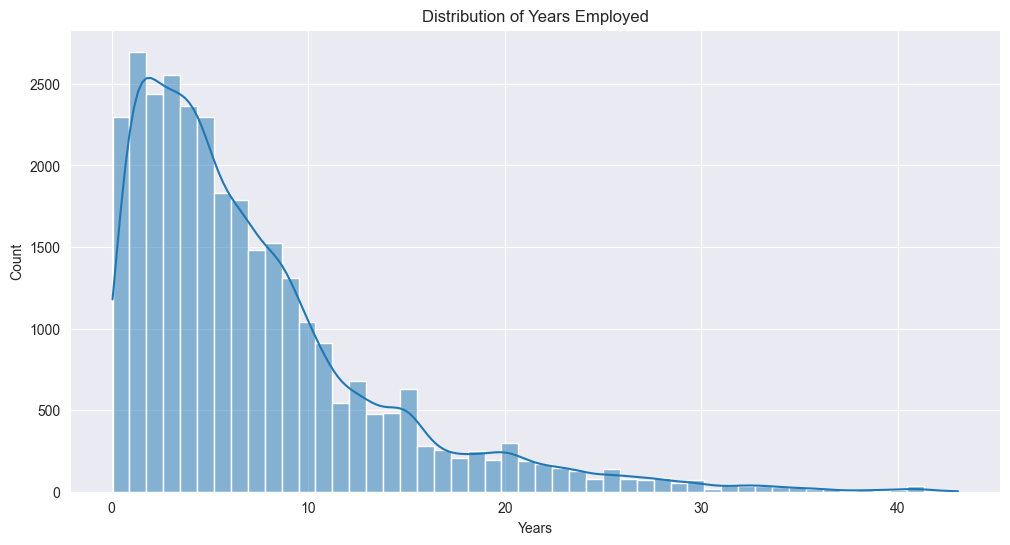


Age when started working (for employed individuals):
count    30322.000000
mean        33.308430
std          9.573617
min         17.936986
25%         25.482192
50%         31.984932
75%         40.164384
max         65.397260
Name: AGE_EMPLOYED, dtype: float64


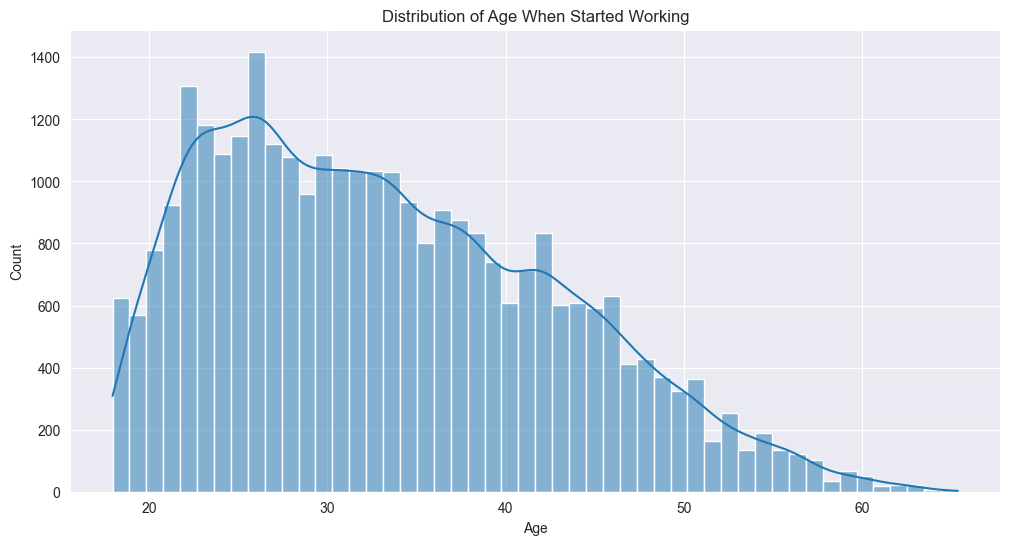

In [4]:
# Create a new column for employment status
combined_df['EMPLOYMENT_STATUS'] = np.where(combined_df['DAYS_EMPLOYED'] < 0, 'Employed', 'Unemployed')

# Print some statistics to verify
print("Employment Status Counts:")
print(combined_df['EMPLOYMENT_STATUS'].value_counts())

print("\nYears Employed Statistics (for Employed individuals):")
print(combined_df['YEARS_EMPLOYED'].describe())

# Visualize the distribution of years employed
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed'], 
             x='YEARS_EMPLOYED', kde=True, bins=50)
plt.title('Distribution of Years Employed')
plt.xlabel('Years')
plt.show()

# Additional analysis: Age when started working
combined_df['AGE_EMPLOYED'] = np.where(combined_df['EMPLOYMENT_STATUS'] == 'Employed', 
                                       combined_df['AGE'] - combined_df['YEARS_EMPLOYED'], np.nan)

print("\nAge when started working (for employed individuals):")
print(combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed']['AGE_EMPLOYED'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed'], 
             x='AGE_EMPLOYED', kde=True, bins=50)
plt.title('Distribution of Age When Started Working')
plt.xlabel('Age')
plt.show()


In [5]:
# Create a cross-tabulation of gender and worst status
gender_status_crosstab = pd.crosstab(combined_df['CODE_GENDER'], combined_df['WORST_STATUS'], normalize='index')

# Print the cross-tabulation
print("\nCross-tabulation of Gender and Worst Status:")
print(gender_status_crosstab)



Cross-tabulation of Gender and Worst Status:
WORST_STATUS         0         1         2         3         4         5  \
CODE_GENDER                                                                
0             0.115074  0.020205  0.001580  0.000333  0.000166  0.001497   
1             0.118625  0.017069  0.001187  0.000205  0.000041  0.001228   

WORST_STATUS         C         X  
CODE_GENDER                       
0             0.325434  0.535711  
1             0.321122  0.540524  


<Figure size 1200x600 with 0 Axes>

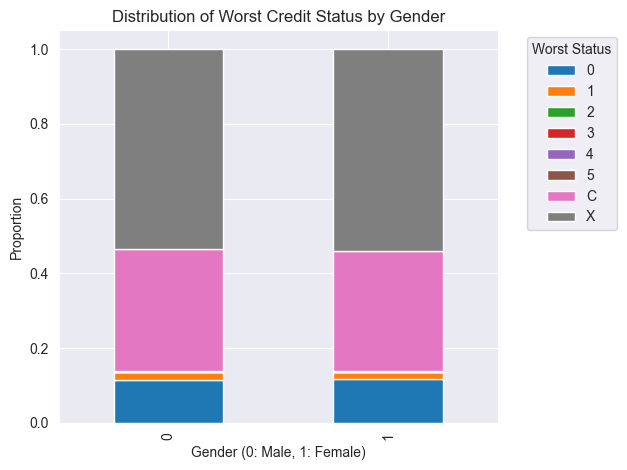

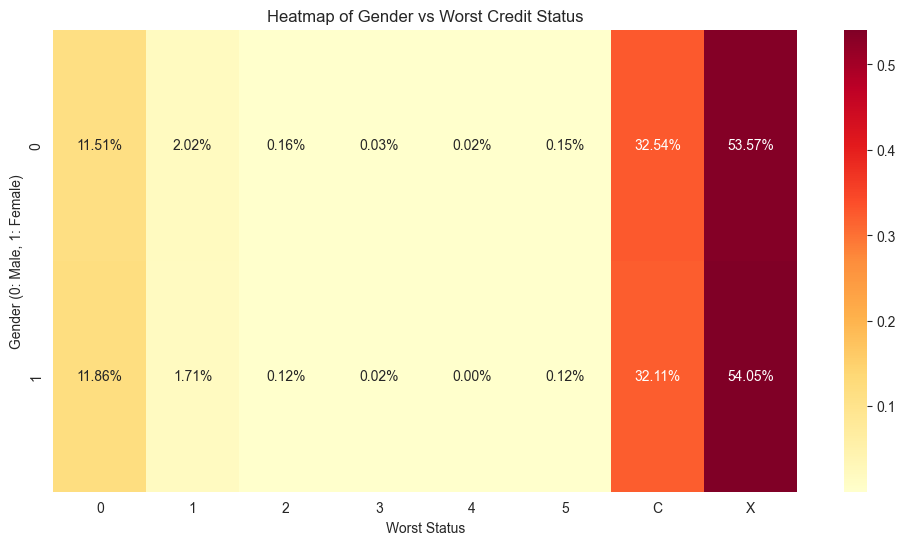

In [6]:
# Stacked bar chart of gender vs worst status
plt.figure(figsize=(12, 6))
gender_status_crosstab.plot(kind='bar', stacked=True)
plt.title('Distribution of Worst Credit Status by Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Heatmap of gender vs worst status
plt.figure(figsize=(12, 6))
sns.heatmap(gender_status_crosstab, annot=True, cmap='YlOrRd', fmt='.2%')
plt.title('Heatmap of Gender vs Worst Credit Status')
plt.ylabel('Gender (0: Male, 1: Female)')
plt.xlabel('Worst Status')
plt.show()


In [7]:
combined_df.head(15)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,MONTHS_ON_BOOK,WORST_STATUS,AGE,YEARS_EMPLOYED,WORST_STATUS_NUM,INCOME_CATEGORY,IS_DEFAULT,AGE_GROUP,EMPLOYMENT_STATUS,AGE_EMPLOYED
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,16,X,32.890411,12.443836,1,High,False,26-35,Employed,20.446575
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,15,X,32.890411,12.443836,1,High,False,26-35,Employed,20.446575
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,30,X,58.832877,3.106849,1,Low,False,56-65,Employed,55.726027
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,5,X,52.356164,8.358904,1,High,False,46-55,Employed,43.997260
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,5,X,52.356164,8.358904,1,High,False,46-55,Employed,43.997260
5,5008810,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,27,X,52.356164,8.358904,1,High,False,46-55,Employed,43.997260
6,5008811,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,39,X,52.356164,8.358904,1,High,False,46-55,Employed,43.997260
7,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,17,X,61.545205,1000.665753,1,High,False,56-65,Unemployed,NaN
8,5008813,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,17,X,61.545205,1000.665753,1,High,False,56-65,Unemployed,NaN
9,5008814,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,17,X,61.545205,1000.665753,1,High,False,56-65,Unemployed,NaN


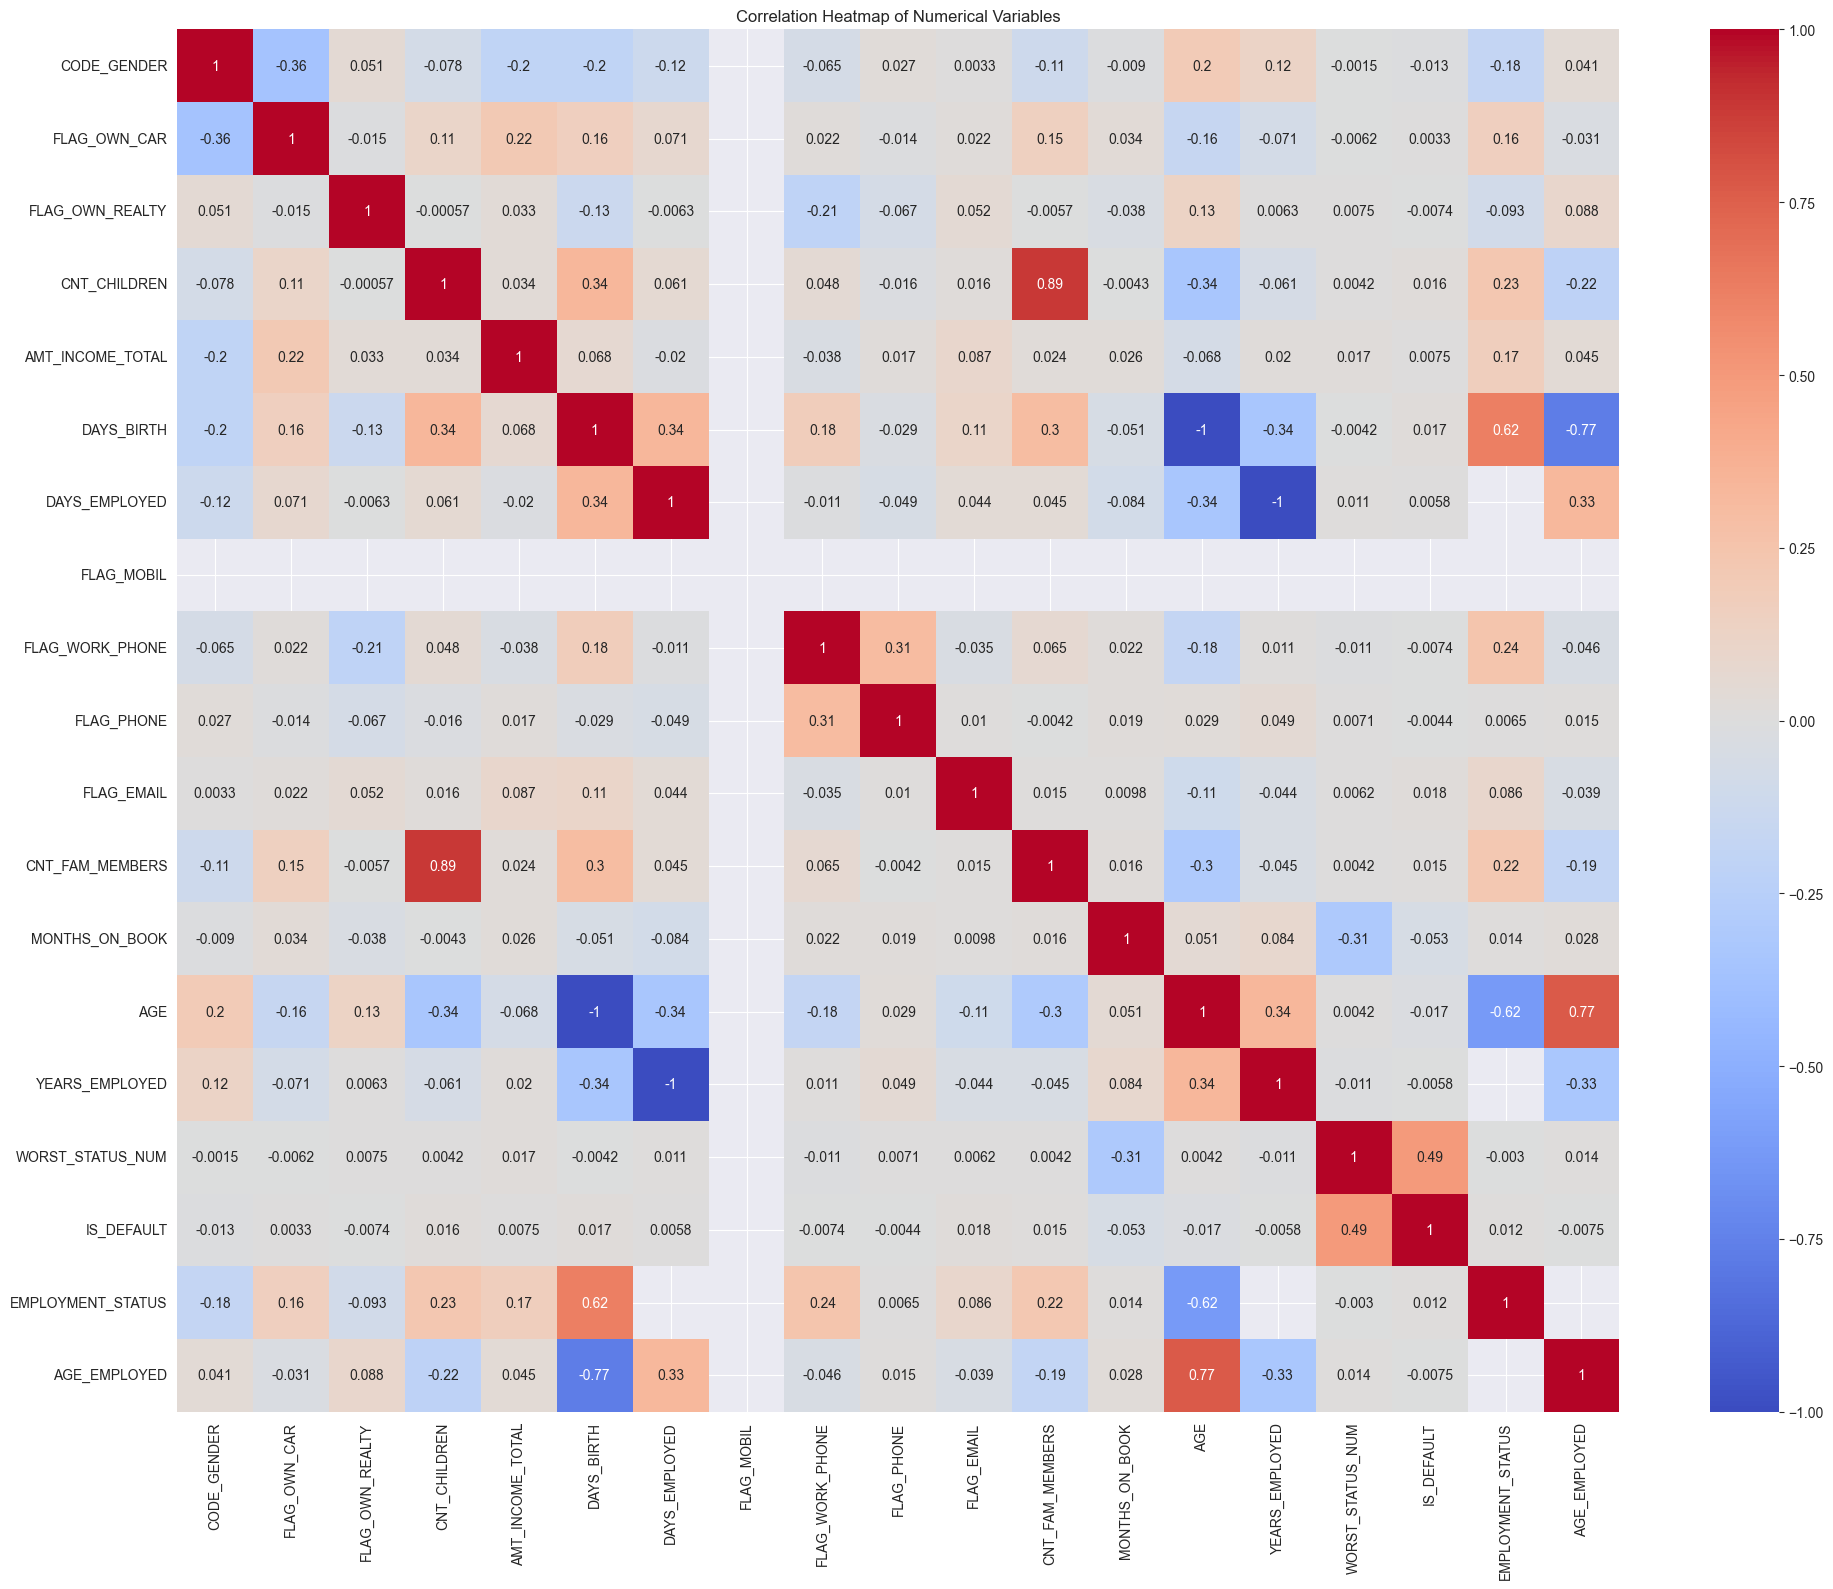

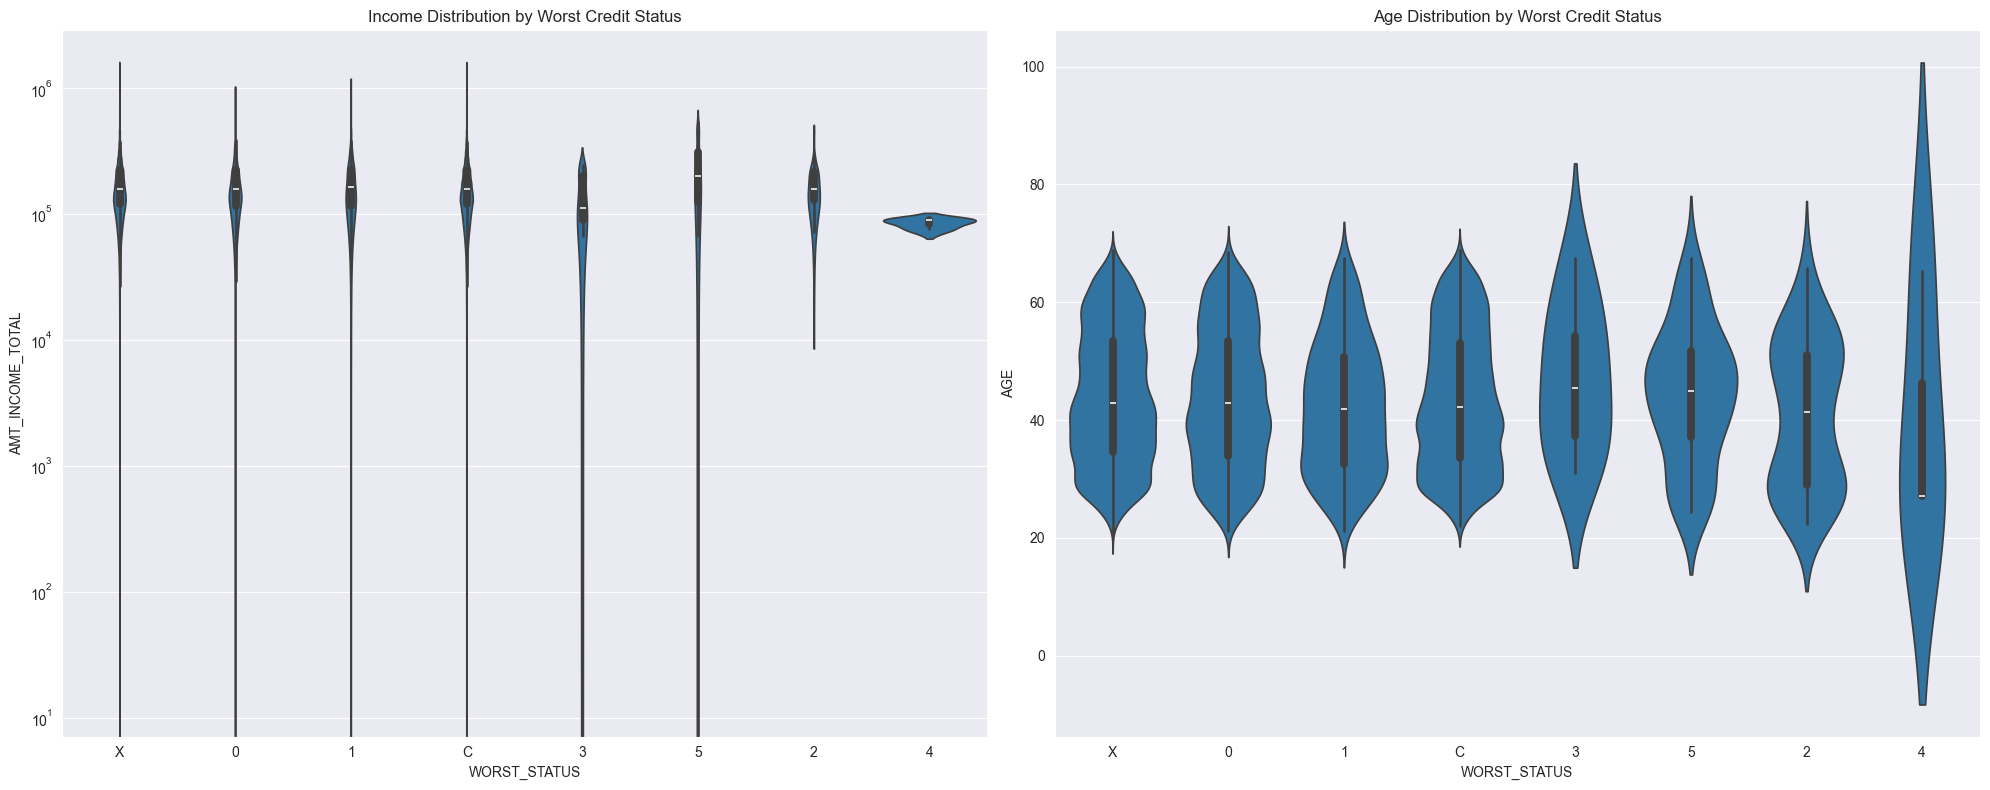

<Figure size 1200x600 with 0 Axes>

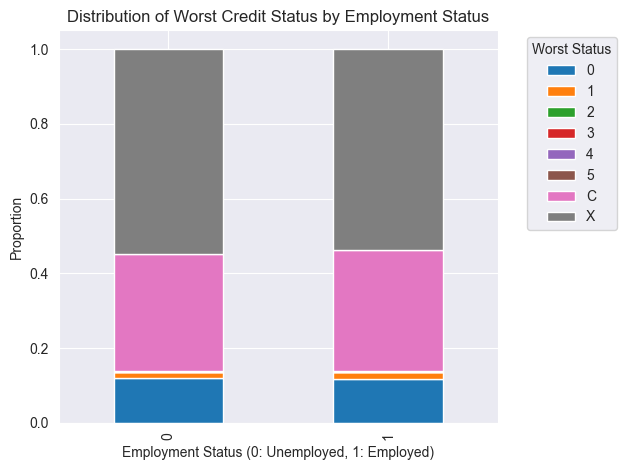

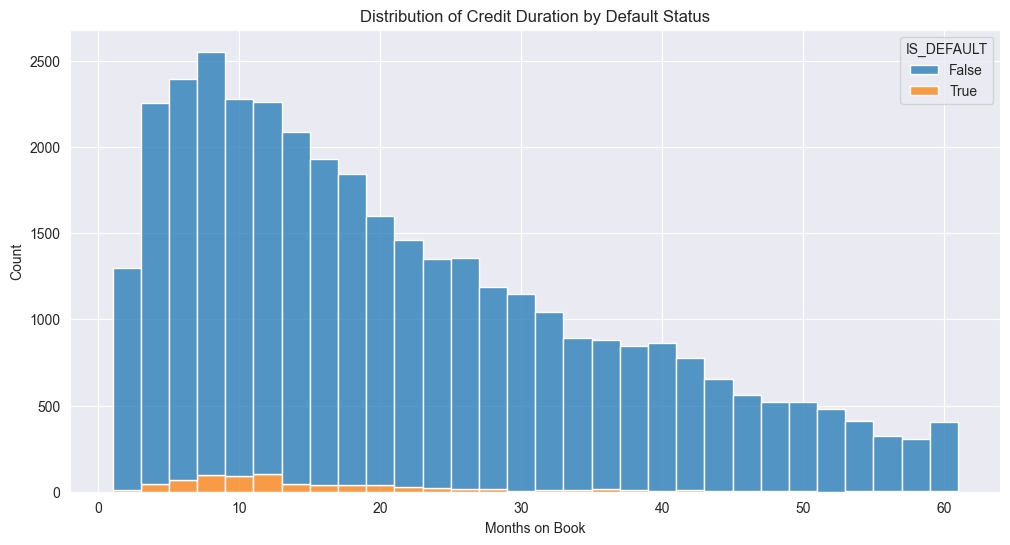

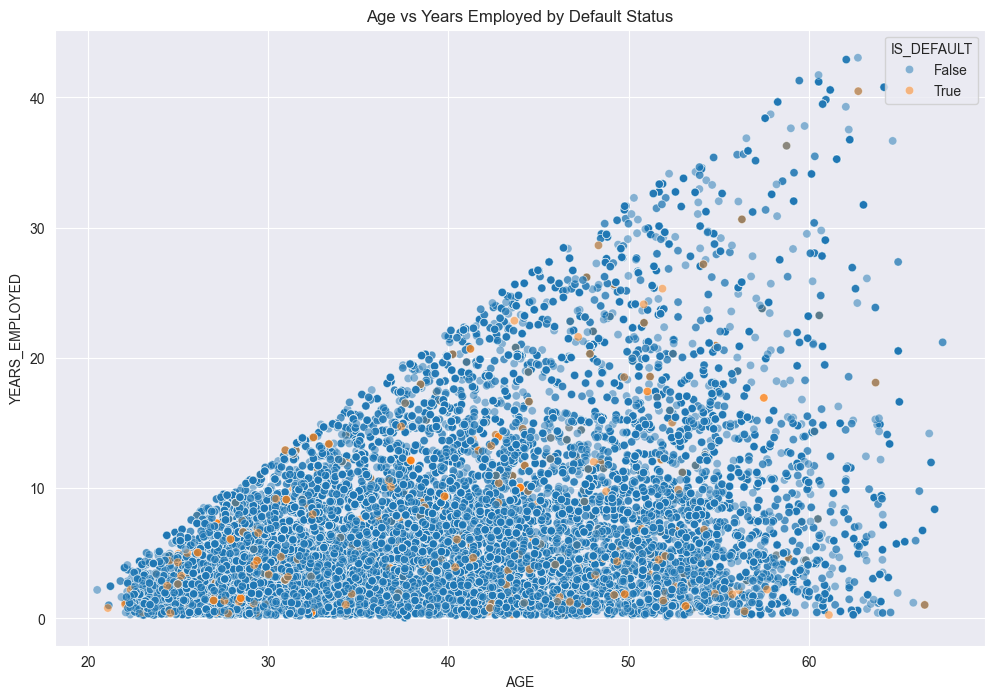

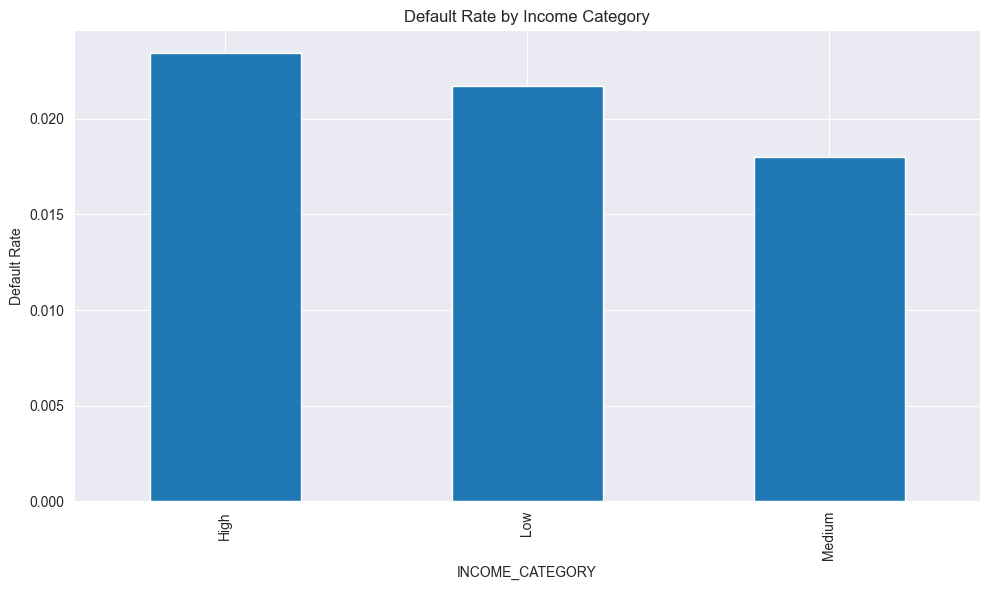

In [8]:
# Replace the placeholder 365243 from DAYS_EMPLOYED field with np.nan
combined_df['DAYS_EMPLOYED'] = combined_df['DAYS_EMPLOYED'].replace(365243, np.nan)

# Update YEARS_EMPLOYED based on the new DAYS_EMPLOYED
combined_df['YEARS_EMPLOYED'] = np.abs(combined_df['DAYS_EMPLOYED']) / 365

# Update EMPLOYMENT_STATUS column
combined_df['EMPLOYMENT_STATUS'] = np.where(combined_df['DAYS_EMPLOYED'].notna(), 1, 0)

# Select numerical columns for analysis
numerical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
'MONTHS_ON_BOOK', 'AGE', 'YEARS_EMPLOYED', 'WORST_STATUS_NUM',
'IS_DEFAULT', 'EMPLOYMENT_STATUS', 'AGE_EMPLOYED']

# Create a correlation matrix
corr_matrix = combined_df[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

# Violin plots for income and age by worst status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.violinplot(x='WORST_STATUS', y='AMT_INCOME_TOTAL', data=combined_df, ax=ax1)
ax1.set_title('Income Distribution by Worst Credit Status')
ax1.set_yscale('log')

sns.violinplot(x='WORST_STATUS', y='AGE', data=combined_df, ax=ax2)
ax2.set_title('Age Distribution by Worst Credit Status')

plt.tight_layout()
plt.show()

# Stacked bar chart for employment status vs worst status
employment_status_crosstab = pd.crosstab(combined_df['EMPLOYMENT_STATUS'], combined_df['WORST_STATUS'], normalize='index')
plt.figure(figsize=(12, 6))
employment_status_crosstab.plot(kind='bar', stacked=True)
plt.title('Distribution of Worst Credit Status by Employment Status')
plt.xlabel('Employment Status (0: Unemployed, 1: Employed)')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Histogram of credit duration (MONTHS_ON_BOOK) by default status
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='MONTHS_ON_BOOK', hue='IS_DEFAULT', multiple='stack', bins=30)
plt.title('Distribution of Credit Duration by Default Status')
plt.xlabel('Months on Book')
plt.show()

# Scatter plot of Age vs Years Employed, colored by default status
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_df, x='AGE', y='YEARS_EMPLOYED', hue='IS_DEFAULT', alpha=0.5)
plt.title('Age vs Years Employed by Default Status')
plt.show()

# Bar plot of default rate by income category
income_default_rate = combined_df.groupby('INCOME_CATEGORY')['IS_DEFAULT'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
income_default_rate.plot(kind='bar')
plt.title('Default Rate by Income Category')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

In [9]:
# Prepare the data
X = combined_df.drop(['IS_DEFAULT', 'WORST_STATUS', 'WORST_STATUS_NUM'], axis=1)
y = combined_df['IS_DEFAULT']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to print class distribution
def print_class_distribution(y):
    print(f"Class distribution:\n{y.value_counts(normalize=True)}")

print("Original distribution:")
print_class_distribution(y_train)

# Approach 1: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

## 1. Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

print("\nDistribution after SMOTE:")
print_class_distribution(y_train_smote)

## 2. Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_imputed, y_train)

print("\nDistribution after Undersampling:")
print_class_distribution(y_train_under)

## 3. Combination of SMOTE and Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_imputed, y_train)

print("\nDistribution after SMOTE-Tomek:")
print_class_distribution(y_train_smote_tomek)


Original distribution:
Class distribution:
IS_DEFAULT
False    0.978845
True     0.021155
Name: proportion, dtype: float64

Distribution after SMOTE:
Class distribution:
IS_DEFAULT
False    0.5
True     0.5
Name: proportion, dtype: float64

Distribution after Undersampling:
Class distribution:
IS_DEFAULT
False    0.5
True     0.5
Name: proportion, dtype: float64

Distribution after SMOTE-Tomek:
Class distribution:
IS_DEFAULT
False    0.5
True     0.5
Name: proportion, dtype: float64


In [10]:
duplicate_columns = X_train_imputed.columns[X_train_imputed.columns.duplicated()].tolist()
print(f"Duplicate columns: {duplicate_columns}")
duplicate_columns = X_test_imputed.columns[X_test_imputed.columns.duplicated()].tolist()
print(f"Duplicate columns: {duplicate_columns}")
print(X_train_imputed)

Duplicate columns: []
Duplicate columns: []
              ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5037048.0          0.0           1.0              1.0           0.0   
1      5044630.0          1.0           1.0              0.0           1.0   
2      5079079.0          1.0           0.0              1.0           2.0   
3      5112872.0          1.0           1.0              1.0           0.0   
4      5105858.0          1.0           0.0              0.0           0.0   
...          ...          ...           ...              ...           ...   
29160  5067139.0          1.0           0.0              1.0           0.0   
29161  5029193.0          1.0           0.0              1.0           1.0   
29162  5047710.0          1.0           0.0              1.0           0.0   
29163  5009886.0          1.0           0.0              1.0           0.0   
29164  5062632.0          1.0           0.0              1.0           0.0   

       AMT_INCOME_T

In [11]:
# Prepare the data (assuming we're using the imputed dataset)
X = X_train_imputed.copy()
y = y_train.copy()

# Feature Engineering
X['DEBT_TO_INCOME'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']

# Check if AGE_GROUP columns already exist
age_group_columns = [col for col in X.columns if col.startswith('AGE_GROUP_')]
if not age_group_columns:
    # If AGE_GROUP columns don't exist, create them
    X['AGE_GROUP'] = pd.cut(X['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    X = pd.get_dummies(X, columns=['AGE_GROUP'])

# Check if INCOME_BRACKET columns already exist
income_bracket_columns = [col for col in X.columns if col.startswith('INCOME_BRACKET_')]
if not income_bracket_columns:
    # If INCOME_BRACKET columns don't exist, create them
    X['INCOME_BRACKET'] = pd.qcut(X['AMT_INCOME_TOTAL'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    X = pd.get_dummies(X, columns=['INCOME_BRACKET'])

# Check for any remaining duplicate columns
duplicate_columns = X.columns[X.columns.duplicated()].tolist()
if duplicate_columns:
    print(f"Duplicate columns found: {duplicate_columns}")
    X = X.loc[:, ~X.columns.duplicated()]

print("Shape of X after feature engineering:", X.shape)
print("Columns in X:", X.columns.tolist())


# One-hot encode new categorical features
# X = pd.get_dummies(X, columns=['AGE_GROUP', 'INCOME_BRACKET'])

# Feature Selection using RFE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=1)
rfe_selector = rfe_selector.fit(X_scaled, y)

selected_features = X.columns[rfe_selector.support_]
X_selected = X[selected_features]

# Apply SMOTE on selected features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train and evaluate multiple models
models = {
'Logistic Regression': LogisticRegression(random_state=42),
'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")



Shape of X after feature engineering: (29165, 65)
Columns in X: ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_ON_BOOK', 'AGE', 'YEARS_EMPLOYED', 'EMPLOYMENT_STATUS', 'AGE_EMPLOYED', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Cleaning staff', 'O

C:\Users\eqvieira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression
              precision    recall  f1-score   support

       False       0.63      0.54      0.58      5687
        True       0.60      0.69      0.64      5733

    accuracy                           0.61     11420
   macro avg       0.62      0.61      0.61     11420
weighted avg       0.62      0.61      0.61     11420

ROC AUC Score: 0.6348

Model: Random Forest
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      5687
        True       0.99      0.98      0.98      5733

    accuracy                           0.98     11420
   macro avg       0.98      0.98      0.98     11420
weighted avg       0.98      0.98      0.98     11420

ROC AUC Score: 0.9944

Model: Gradient Boosting
              precision    recall  f1-score   support

       False       0.85      0.98      0.91      5687
        True       0.98      0.83      0.90      5733

    accuracy                           0.91     11420
   macro

                                  feature  importance
2                          MONTHS_ON_BOOK    0.191469
14                 INCOME_CATEGORY_Medium    0.174903
0                           DAYS_EMPLOYED    0.144733
4                            AGE_EMPLOYED    0.112614
16                        AGE_GROUP_36-45    0.085970
15                        AGE_GROUP_26-35    0.062484
17                        AGE_GROUP_46-55    0.061380
1                              FLAG_EMAIL    0.043077
8     NAME_HOUSING_TYPE_House / apartment    0.042808
18                        AGE_GROUP_56-65    0.030116
12         NAME_HOUSING_TYPE_With parents    0.014979
9   NAME_HOUSING_TYPE_Municipal apartment    0.011729
19                          AGE_GROUP_65+    0.006936
5              NAME_INCOME_TYPE_Pensioner    0.004706
3                       EMPLOYMENT_STATUS    0.003991
11     NAME_HOUSING_TYPE_Rented apartment    0.003387
10     NAME_HOUSING_TYPE_Office apartment    0.002740
7     NAME_EDUCATION_TYPE_Lo

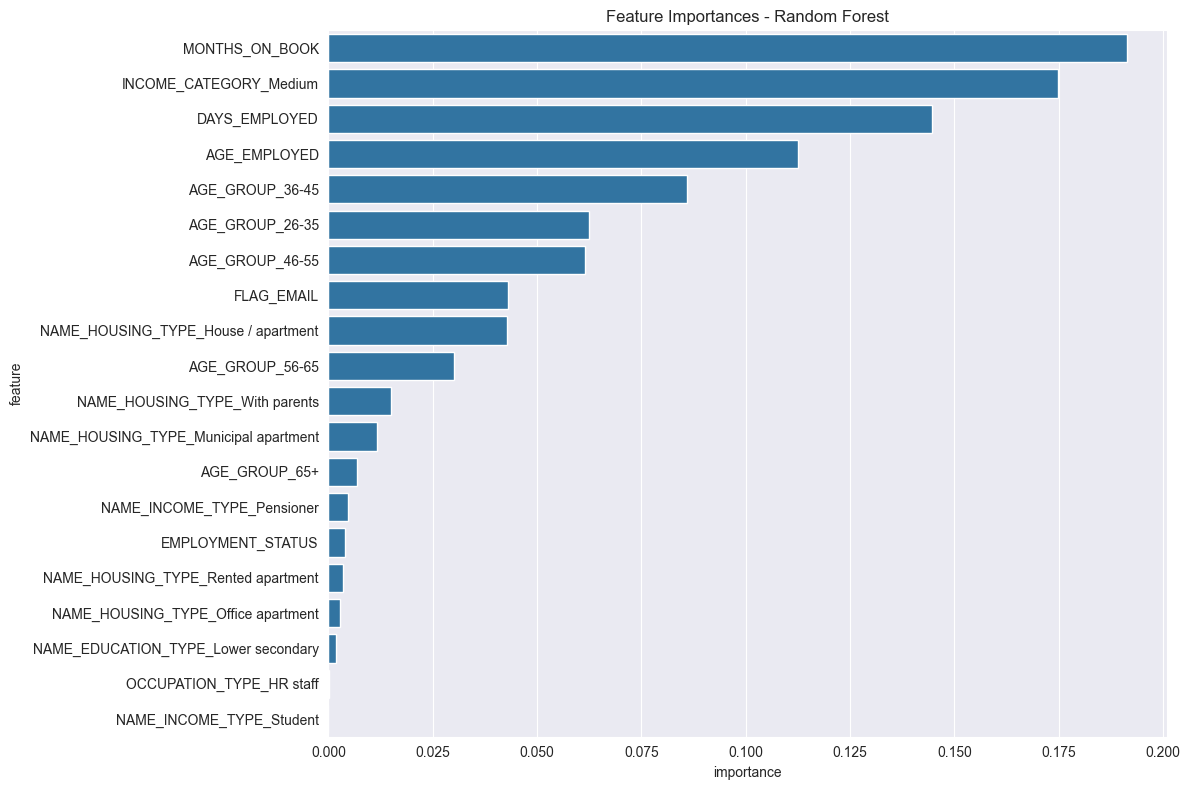


Misclassified Samples Statistics:
       DAYS_EMPLOYED  FLAG_EMAIL  MONTHS_ON_BOOK  EMPLOYMENT_STATUS  \
count     217.000000  217.000000      217.000000         217.000000   
mean    -2515.304697    0.073733       15.739472           0.580645   
std      1900.885462    0.261940       11.047402           0.494594   
min    -14338.000000    0.000000        1.000000           0.000000   
25%     -2653.256256    0.000000        8.000000           0.000000   
50%     -2653.256256    0.000000       12.000000           1.000000   
75%     -1345.000000    0.000000       19.000000           1.000000   
max       -89.000000    1.000000       54.000000           1.000000   

       AGE_EMPLOYED  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_Student  \
count    217.000000                  217.000000                     217.0   
mean      32.958921                    0.423963                       0.0   
std        7.195986                    0.495327                       0.0   
min       18.0383

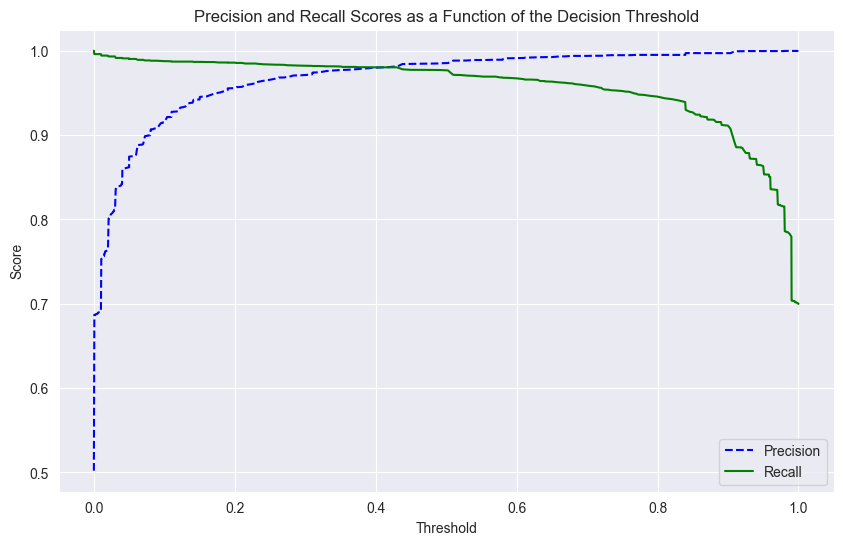


Best threshold for F1 score: 0.4379

Model performance with best threshold:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      5687
        True       0.98      0.98      0.98      5733

    accuracy                           0.98     11420
   macro avg       0.98      0.98      0.98     11420
weighted avg       0.98      0.98      0.98     11420

ROC AUC Score: 0.9944
Train Accuracy: 0.9922
Test Accuracy: 0.9810


In [12]:
# Feature importance analysis for the best performing model (Random Forest in this case)
best_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

# Analyze misclassifications
y_pred = best_model.predict(X_test)
misclassified = X_test.loc[y_pred != y_test].copy()
misclassified.loc[:, 'true_label'] = y_test[y_pred != y_test].values
misclassified.loc[:, 'predicted_label'] = y_pred[y_pred != y_test]

print("\nMisclassified Samples Statistics:")
print(misclassified.describe())

# # Analyze feature distributions for correctly classified vs misclassified samples
# for feature in X_selected.columns:
#     plt.figure(figsize=(10, 6))
#     sns.kdeplot(data=X_test[y_pred == y_test], x=feature, label='Correct', fill=True)
#     sns.kdeplot(data=X_test[y_pred != y_test], x=feature, label='Misclassified', fill=True)
#     plt.title(f'Distribution of {feature} for Correct vs Misclassified Samples')
#     plt.legend()
#     plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Scores as a Function of the Decision Threshold')
plt.legend()
plt.show()

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

print(f"\nBest threshold for F1 score: {best_threshold:.4f}")

# Evaluate model performance with the best threshold
y_pred_best_threshold = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
print("\nModel performance with best threshold:")
print(classification_report(y_test, y_pred_best_threshold))
print(f"ROC AUC Score: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_accuracy = (y_train_pred == y_train).mean()
test_accuracy = (y_test_pred == y_test).mean()

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [13]:
def add_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    noisy_X = X.copy()
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            noisy_X[col] += noise[:, X.columns.get_loc(col)]
    return noisy_X

X_test_noisy = add_noise(X_test)
y_pred_noisy = best_model.predict(X_test_noisy)
noisy_accuracy = (y_pred_noisy == y_test).mean()

print(f"Accuracy with 5% noise: {noisy_accuracy:.4f}")


Accuracy with 5% noise: 0.5195



Model performance with best threshold:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      5687
        True       0.98      0.98      0.98      5733

    accuracy                           0.98     11420
   macro avg       0.98      0.98      0.98     11420
weighted avg       0.98      0.98      0.98     11420

ROC AUC Score: 0.9944


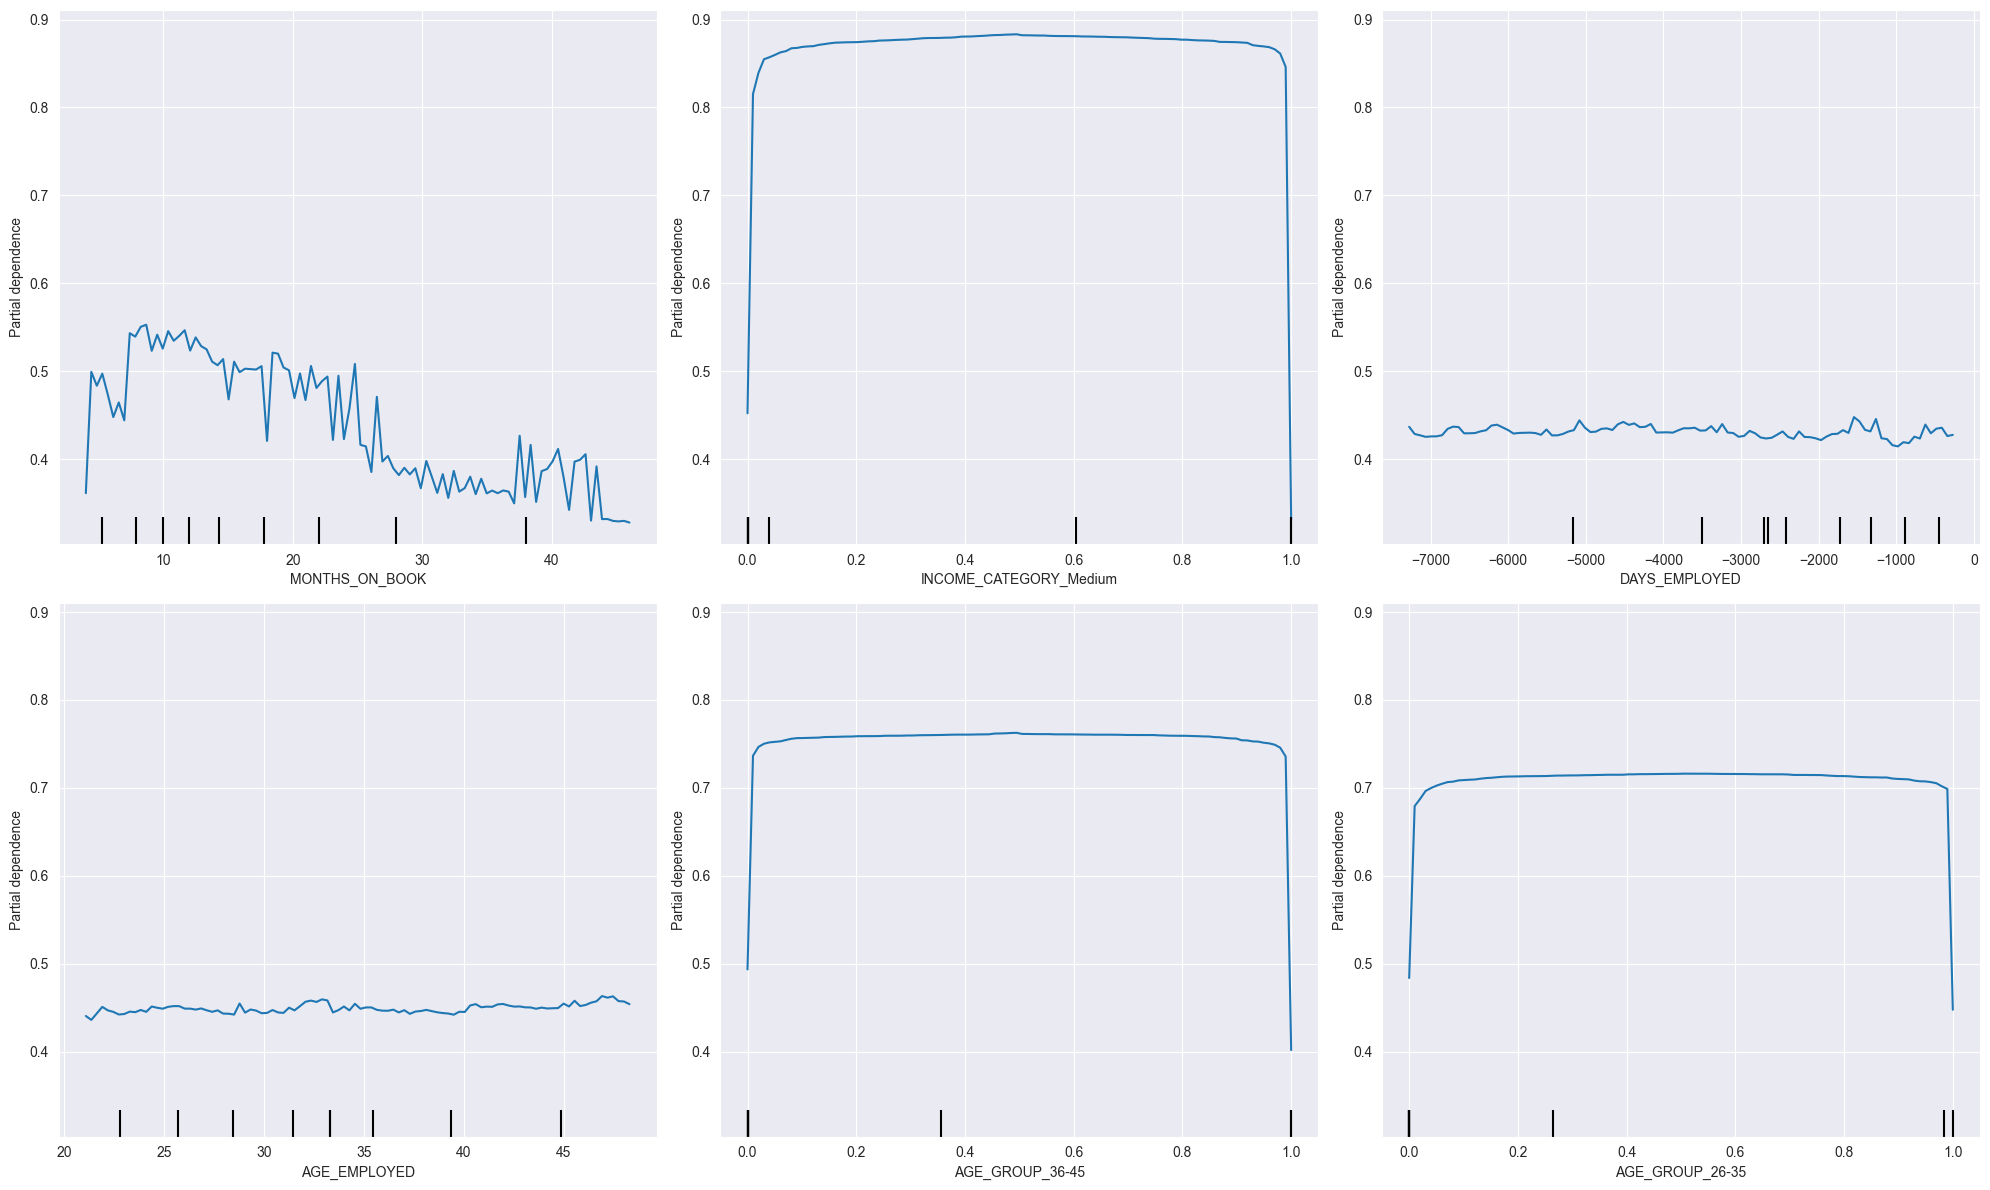


Cross-validation ROC AUC scores: [0.9822775  0.99874865 0.99861532 0.9990252  0.99880063]
Mean ROC AUC: 0.9955 (+/- 0.0132)


In [14]:
# Evaluate the model with the new threshold
y_pred_best_threshold = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

print("\nModel performance with best threshold:")
print(classification_report(y_test, y_pred_best_threshold))
print(f"ROC AUC Score: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")

# Partial Dependence Plots
features = feature_importance['feature'].head(6).tolist()  # Top 6 important features
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
PartialDependenceDisplay.from_estimator(best_model, X_test, features, ax=ax.ravel())
plt.tight_layout()
plt.show()

# Cross-validation to ensure model stability
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Default Rates by Risk Category:
risk_category
High Risk        0.988970
Medium Risk      0.492308
Low Risk         0.168539
Very Low Risk    0.014569
Name: IS_DEFAULT, dtype: float64


C:\Users\eqvieira\AppData\Local\Temp\ipykernel_5648\2238376474.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = X_test_with_score.groupby('risk_category')['IS_DEFAULT'].mean().sort_values(ascending=False)


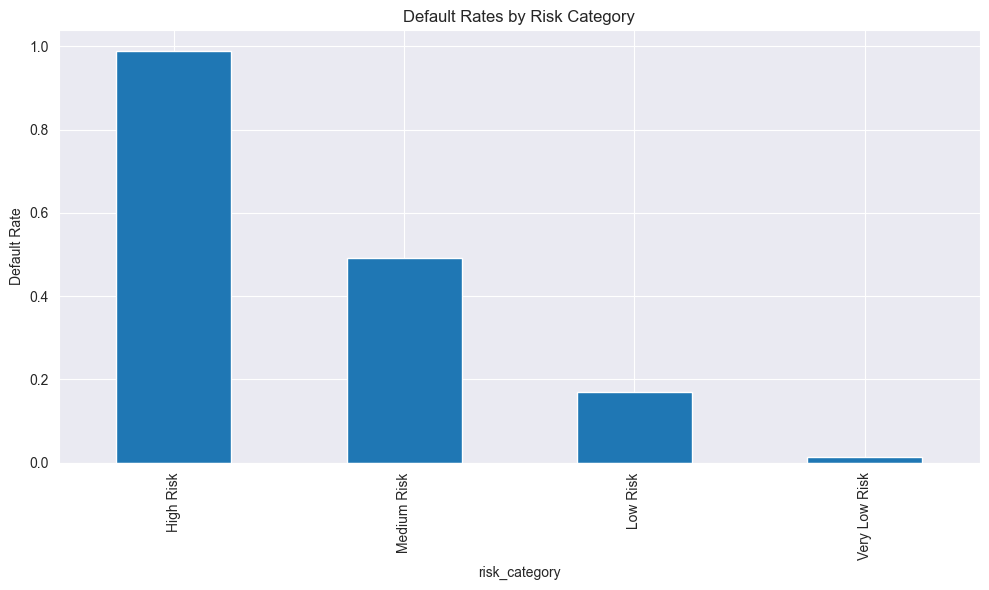

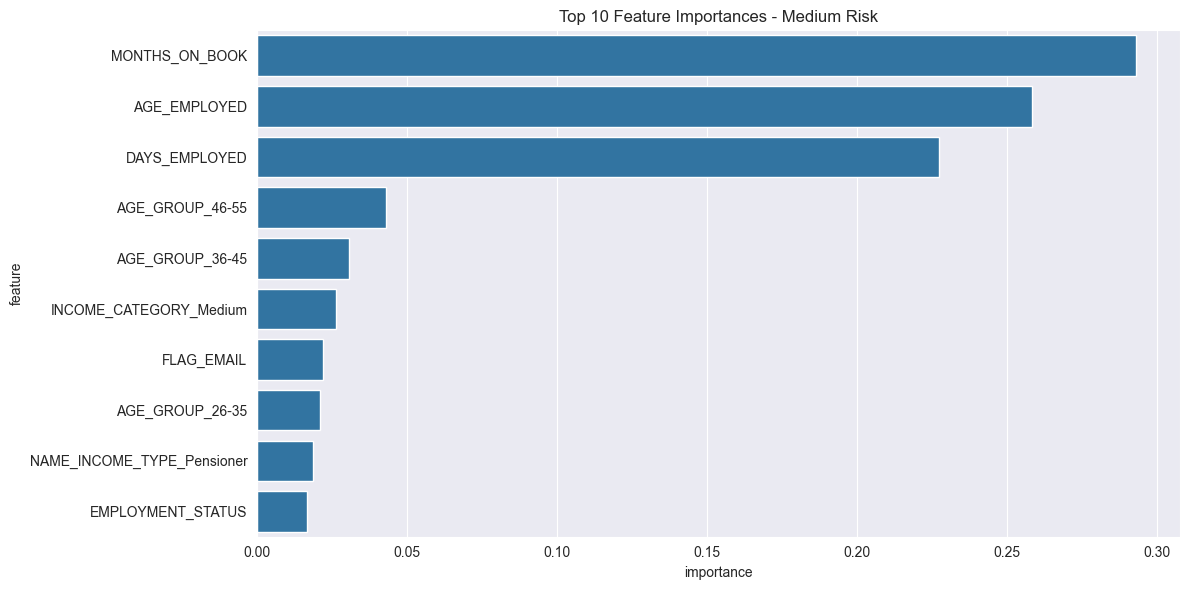

                                  feature  importance
2                          MONTHS_ON_BOOK    0.292927
4                            AGE_EMPLOYED    0.258245
0                           DAYS_EMPLOYED    0.227142
17                        AGE_GROUP_46-55    0.042855
16                        AGE_GROUP_36-45    0.030698
14                 INCOME_CATEGORY_Medium    0.026192
1                              FLAG_EMAIL    0.022049
15                        AGE_GROUP_26-35    0.020856
5              NAME_INCOME_TYPE_Pensioner    0.018544
3                       EMPLOYMENT_STATUS    0.016768
8     NAME_HOUSING_TYPE_House / apartment    0.013960
18                        AGE_GROUP_56-65    0.013416
11     NAME_HOUSING_TYPE_Rented apartment    0.005738
19                          AGE_GROUP_65+    0.004609
9   NAME_HOUSING_TYPE_Municipal apartment    0.004337
12         NAME_HOUSING_TYPE_With parents    0.001663
10     NAME_HOUSING_TYPE_Office apartment    0.000000
7     NAME_EDUCATION_TYPE_Lo

In [15]:
# Risk Scoring
# Create a function to convert model probabilities into risk scores (e.g., 300-850 range)
def prob_to_score(prob, min_score=300, max_score=850):
    return int(min_score + (max_score - min_score) * (1 - prob))

# Apply the scoring function to the test set
y_prob = best_model.predict_proba(X_test)[:, 1]
X_test_with_score = X_test.copy()
X_test_with_score['risk_score'] = [prob_to_score(p) for p in y_prob]
X_test_with_score['IS_DEFAULT'] = y_test.values # Add the actual default status

# Create risk categories
X_test_with_score['risk_category'] = pd.cut(X_test_with_score['risk_score'],
bins=[0, 550, 650, 750, 850],
labels=['High Risk', 'Medium Risk', 'Low Risk', 'Very Low Risk'])

# Analyze default rates by risk category
default_rates = X_test_with_score.groupby('risk_category')['IS_DEFAULT'].mean().sort_values(ascending=False)
print("\nDefault Rates by Risk Category:")
print(default_rates)

# Visualize default rates by risk category
plt.figure(figsize=(10, 6))
default_rates.plot(kind='bar')
plt.title('Default Rates by Risk Category')
plt.ylabel('Default Rate')
plt.tight_layout()
plt.show()

# Feature importance by risk category
for category in X_test_with_score['risk_category'].unique():
    category_data = X_test_with_score[X_test_with_score['risk_category'] == category]
    category_y =  category_data['IS_DEFAULT']
    category_X = category_data.drop(['risk_score', 'risk_category', 'IS_DEFAULT'], axis=1)
    category_model = RandomForestClassifier(n_estimators=100, random_state=42)

category_model.fit(category_data[X_selected.columns], category_y)

feature_importance = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': category_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title(f'Top 10 Feature Importances - {category}')
plt.tight_layout()
plt.show()
print(feature_importance)

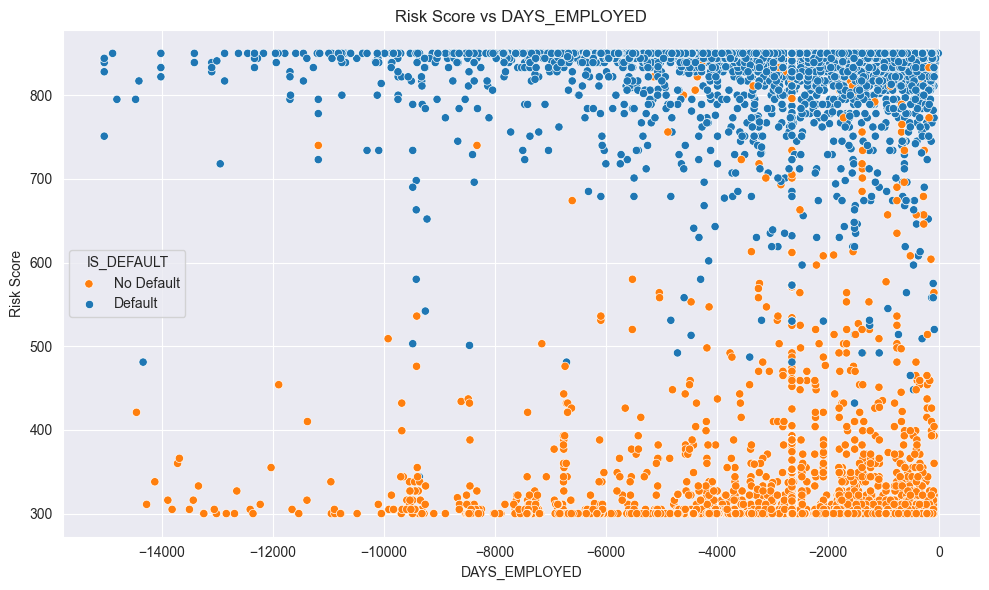

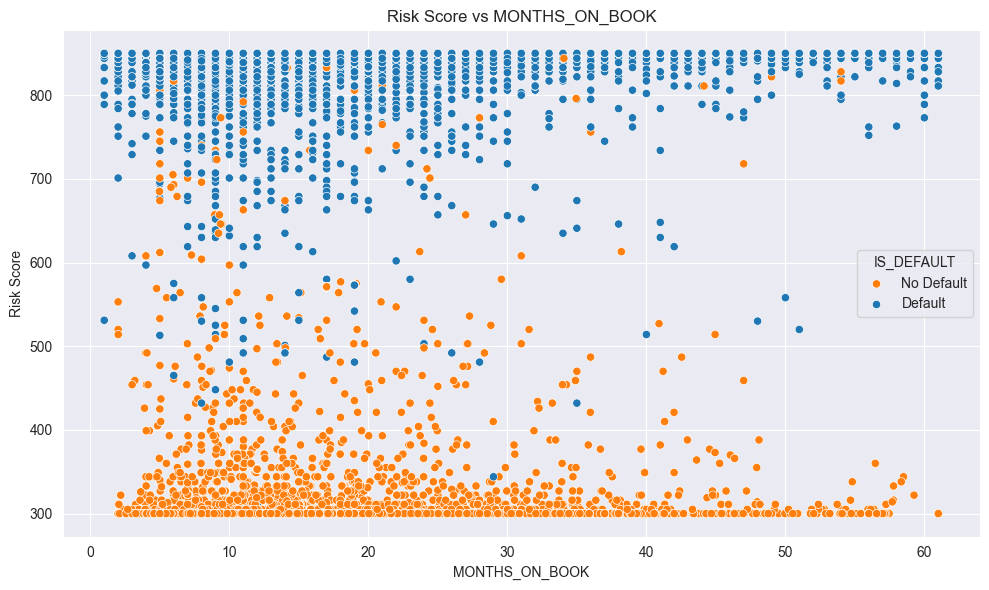

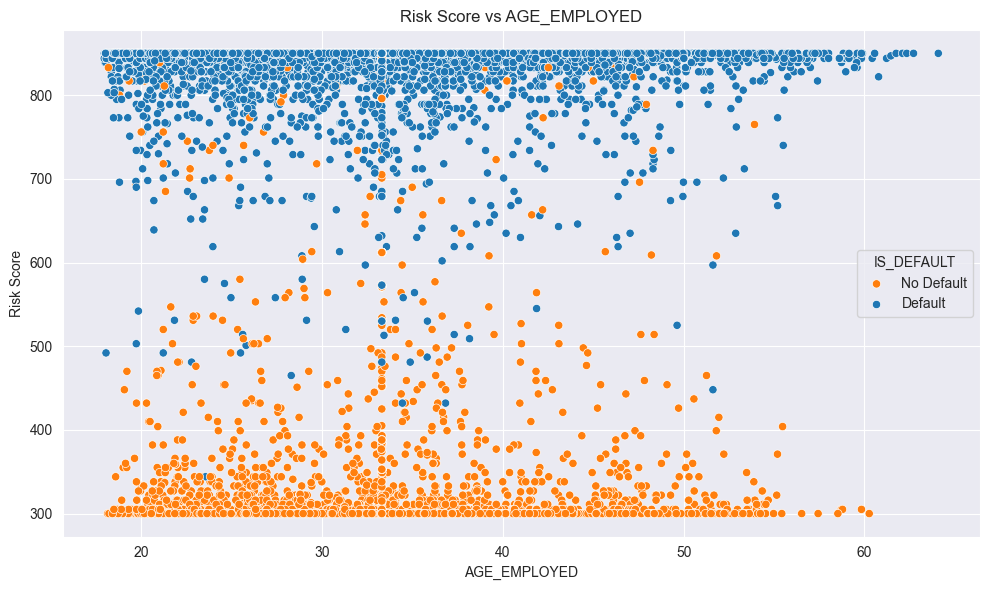

In [16]:
# Additional analysis: Average risk score by specific features
selected_features = ['DAYS_EMPLOYED', 'MONTHS_ON_BOOK', 'AGE_EMPLOYED']

for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='risk_score', hue='IS_DEFAULT', data=X_test_with_score)
    plt.title(f'Risk Score vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Risk Score')
    plt.legend(title='IS_DEFAULT', labels=['No Default', 'Default'])
    plt.tight_layout()
    plt.show()
